In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
from jax.numpy.linalg import norm as l2
import numpy as np
from typing import List, Dict, Tuple
from itertools import product

In [2]:
class ElasticNetwork(nx.Graph):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos = {}
    
    def energy(self, params=None) -> float:
        U = 0
        pos = self.pos if params is None else params
        for u, v, d in self.edges(data=True):
            r = l2(pos[u] - pos[v])
            dr = r - d['rest_length'] 
            U += d['weight'] * dr * dr
        return U
    
    def sample(self, length, init=None, seed=42, sigma=0.1, T=1, update=True) -> List[Dict]:
        """
        Do Metropolis Monte Carlo sampling of possible system configurations,
        and return them in a list. For every step, a random Gaussian noise is
        used to perturb the position of all nodes.
        """
        if init is None:
            init = dict(self.pos)
        rng_key = jax.random.PRNGKey(seed)
        traj = [init]
        
        @jax.jit # seems pretty fast
        def aux(rng_key):
            next_state = dict(traj[-1])
            for k, v in next_state.items(): # this part could be optimized later
                rng_key, key = jax.random.split(rng_key, 2)
                next_state[k] = v + jax.random.normal(key=key, shape=v.shape)*sigma
            E_last = self.energy(params=traj[-1])
            E_curr = self.energy(params=next_state)
            rng_key, key = jax.random.split(rng_key, 2)
            return rng_key, E_last, E_curr, next_state
        
        while length > 1:
            rng_key, E_last, E_curr, next_state = aux(rng_key)
            if np.random.uniform() <= min(1, np.exp(-1/T*(E_curr-E_last))): # kb=1
                traj.append(next_state)
                length-=1
            
        if update:
            self.pos = dict(traj[-1])
        return traj
        
    def minimize(self, epochs=100):
        params = dict(self.pos)
        optimizer = optax.sgd(learning_rate=0.1)
        opt_state = optimizer.init(params)
        
        @jax.jit
        def step(params, opt_state):
            loss_value, grads = jax.value_and_grad(self.energy)(params)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value

        for _ in range(epochs):
            params, opt_state, loss_value = step(params, opt_state)
            
        print(f"Energy after minimization: {loss_value}")
        self.pos = params
    
    def draw(self, ax=None, figsize=(5,5)):
        if ax is None:
            fig, ax = plt.subplots(1, figsize=figsize)
        options = {'node_color': 'black', 'node_size': 100, 'width': 3, 'font_size': 8}
        nx.draw_networkx(self, pos=self.pos, **options, ax=ax)
        nx.draw_networkx_edge_labels(self, pos=self.pos, font_size=8, ax=ax,
                                     edge_labels={(u,v): f"({l['weight']:.2f},{l['rest_length']:.2f})"\
                                                  for u,v,l in self.edges(data=True)})
    
    def init_pos(self, *args, **kwargs):
        self.pos = nx.spring_layout(self, *args, **kwargs)
        for k, v in self.pos.items():
            self.pos[k] = jnp.array(v)
    
    def add_node(self, node_for_adding, *args, position=None, **kwargs):
        super().add_node(node_for_adding, *args, **kwargs)
        if position is not None:
            self.pos[node_for_adding] = jnp.array(position)
        
    def add_nodes(self, nodes_for_adding, *args, positions=None, **kwargs):
        for node, pos in zip(nodes_for_adding, positions):
            self.add_node(node_for_adding=node, *args, position=pos, **kwargs)
    
    def add_spring(self, v1, v2, weight, rest_length=None):
        if rest_length is None:
            rest_length = float(l2(self.pos[v1] - self.pos[v2]))
        self.add_edge(v1, v2, rest_length=rest_length, weight=weight)
        
    def add_springs(self, v1s: List, v2s: List, weights: List, rest_lengths: List):
        for v1, v2, weight, rest_length in zip(v1s, v2s, weights, rest_lengths):
            self.add_spring(v1, v2, weight, rest_length)

In [3]:
G = ElasticNetwork()
G.add_nodes(nodes_for_adding=range(4), 
            positions=[jnp.array([-0.5, -0.5]),
                       jnp.array([-0.5, 0.5]),
                       jnp.array([0.5, -0.5]),
                       jnp.array([0.5, 0.5])])
G.add_springs(v1s=[0, 1, 0, 0, 2, 1],
              v2s=[1, 2, 2, 3, 3, 3],
              weights=[1, 1, 1, 1, 1, 1],
              rest_lengths=[1, 1, 1, 1.2, 1.2, 1.5])

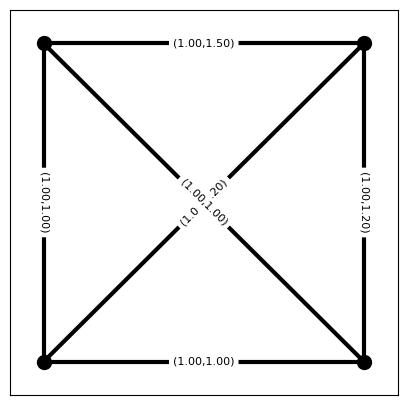

In [4]:
G.draw()

In [5]:
G.pos

{0: DeviceArray([-0.5, -0.5], dtype=float32),
 1: DeviceArray([-0.5,  0.5], dtype=float32),
 2: DeviceArray([ 0.5, -0.5], dtype=float32),
 3: DeviceArray([0.5, 0.5], dtype=float32)}

In [6]:
G.energy()

DeviceArray(0.5074603, dtype=float32)

In [7]:
G.minimize()

Energy after minimization: 0.28506138920783997


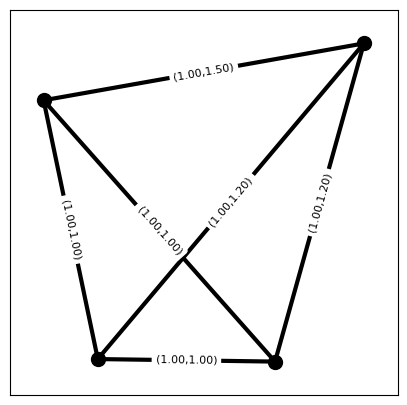

In [8]:
G.draw()

In [9]:
%%time
traj = G.sample(length=100_000, sigma=0.1)

CPU times: user 2.36 s, sys: 190 ms, total: 2.55 s
Wall time: 2.27 s


In [10]:
G.energy()

DeviceArray(0.31511018, dtype=float32)

(array([5.5530e+04, 3.3086e+04, 8.6150e+03, 2.1250e+03, 5.0400e+02,
        9.8000e+01, 2.9000e+01, 8.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([0.28506136, 0.38105232, 0.47704324, 0.57303417, 0.66902512,
        0.76501608, 0.86100703, 0.95699799, 1.05298889, 1.1489799 ,
        1.2449708 ]),
 <BarContainer object of 10 artists>)

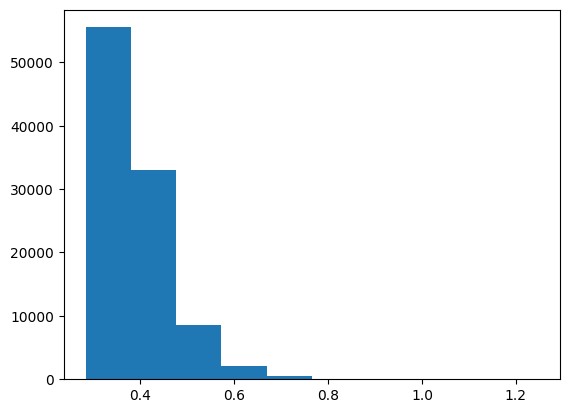

In [11]:
energy = []
for pos in traj:
    G.pos = pos
    energy.append(G.energy()) # pretty slow, can be optimized
plt.hist(energy)

In [12]:

class RectangularMesh(ElasticNetwork):
    def __init__(self, width, height, *args, dx=1., dy=1., weight=1, eps_weight=0, seed=42, **kwargs):
        super().__init__(*args, **kwargs)
        self.width = width
        self.height = height
        self.weight = weight
        self.eps_weight = eps_weight
        np.random.seed(seed)
        for nx, ny in product(range(self.width), range(self.height)):
            self.add_node((nx,ny), position=(nx*dx, ny*dy))
        for nx, ny in product(range(self.width), range(self.height)):
            if nx < width-1:
                self.add_spring((nx, ny), (nx+1, ny), 
                              weight=self.random_weight())
            if ny < height-1:
                self.add_spring((nx, ny), (nx, ny+1),
                             weight=self.random_weight())

    def random_weight(self):
        return np.random.uniform(self.weight-self.eps_weight, 
                                 self.weight+self.eps_weight)

class RectangularTriangulatedMesh(RectangularMesh):
    def __init__(self, width, height, *args, dx=1., dy=1., weight=1, eps_weight=0, seed=42, **kwargs):
        super().__init__(width, height, *args, dx=dx, dy=dy, weight=weight, eps_weight=eps_weight, seed=seed, **kwargs)
        
        for nx, ny in product(range(self.width-1), range(self.height-1)):
            self.add_spring((nx, ny), (nx+1, ny+1), 
                          weight=self.random_weight())
            
class RectangularDoublyTriangulatedMesh(RectangularTriangulatedMesh):
    def __init__(self, width, height, *args, dx=1., dy=1., weight=1, eps_weight=0, seed=42, **kwargs):
        super().__init__(width, height, *args, dx=dx, dy=dy, weight=weight, eps_weight=eps_weight, seed=seed, **kwargs)
        
        for nx, ny in product(range(1, self.width), range(self.height-1)):
            self.add_spring((nx, ny), (nx-1, ny+1), 
                          weight=self.random_weight())

def build_rectangular_triangulated_mesh(width, height, dx=1., dy=1., 
                                        weight=1, eps_weight=0, seed=42) -> ElasticNetwork:
    np.random.seed(seed)
    EN = build_rectangular_mesh(width, height, dx, dy, weight, eps_weight, seed)
    
    for nx, ny in product(range(1, width), range(height)):
        EN.add_spring((nx, ny), (nx-1, ny+1), 
                      weight=random_weight())
    return EN
            
def build_rectangular_doubly_triangulated_mesh(width, height, dx=1., dy=1., 
                                               weight=1, eps_weight=0, seed=42) -> ElasticNetwork:
    np.random.seed(seed)
    EN = build_rectangular_triangulated_mesh(width, height, dx, dy, weight, eps_weight, seed)
    return EN
    
    

In [13]:
mesh = RectangularDoublyTriangulatedMesh(width=3, height=3, eps_weight=0.05)

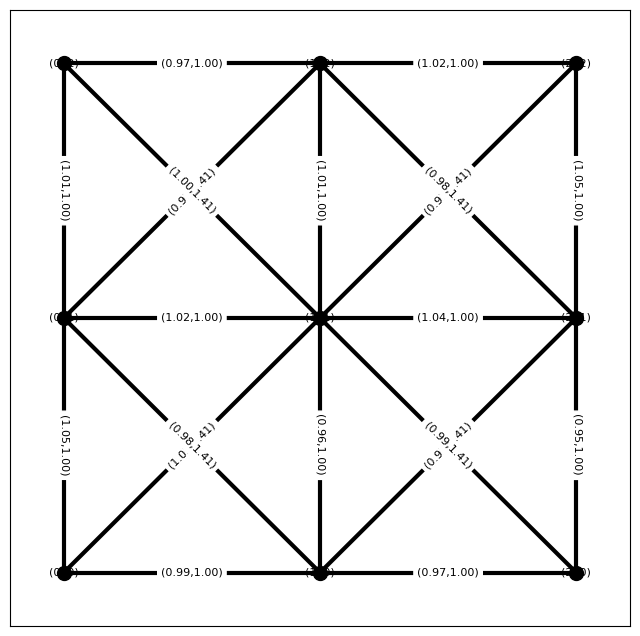

In [14]:
mesh.draw(figsize=(8,8))

In [15]:
%%time
traj=mesh.sample(length=10000)

CPU times: user 1.48 s, sys: 203 ms, total: 1.68 s
Wall time: 1.37 s


In [16]:
mesh.pos = traj[-30]

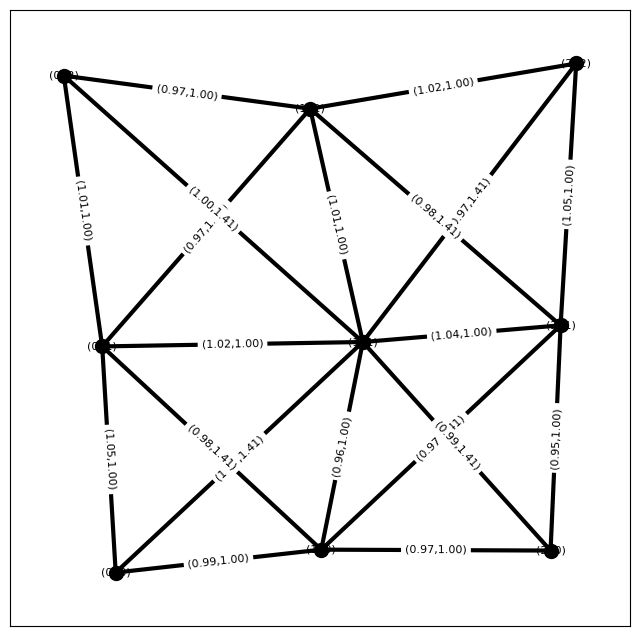

In [17]:
mesh.draw(figsize=(8,8))

In [18]:
mesh.energy()

DeviceArray(0.293882, dtype=float32)

now we define a Graph Normalizing Flow network based on https://arxiv.org/abs/1905.13177.
    
The idea is that given a graph with additional vertex data describing node positions and edge data describing the spring constant for the link between every pair of nodes, we can evaluate the energy of the elastic network of the graph, and thus modulo translation and rotation of all coordinates, we have a well-defined canonical distribution over all graphs with the same connectivity and spring constants. This distribution can be modelled by a graph normalizing flow network that iteratively transforms a base distribution, e.g., Gaussian for all node coordinates, into this target distribution.


In [19]:
import jraph
import haiku as hk

n_hidden_dim = 16
output_dim=2
hidden_dim=16
half_dim = output_dim//2

# this is clearly inspired by RealNVP

def replace_node_features(g: jraph.GraphsTuple, new_nodes) -> jraph.GraphsTuple:
    nodes, edges, receivers, senders, globals_, n_node, n_edge = g
    n_node = jnp.array([len(nodes)])
    return jraph.GraphsTuple(new_nodes, edges, receivers, senders, globals_, n_node, n_edge)

class GraphNetwork(hk.Module):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(name=name)
        self.model = jraph.GraphNetwork(*args, **kwargs)
    
    def __call__(self, g):
        return self.model(g)

class GRevHalfLayer(hk.Module):
    def __init__(self, dim, hidden_dim = 16, name=None):
        super().__init__(name=name)
        self.dim = dim
        self.half_dim = dim // 2
        assert dim % 2 == 0
        edge_output_sizes = [hidden_dim, hidden_dim, dim]
        node_output_sizes = [hidden_dim, hidden_dim, half_dim]
        # The MLP setup is for initial testing, and it works, 
        # but we will use MPNN since we work with graphs
        #self.mp_trans = hk.nets.MLP(output_sizes)  
        #self.mp_scale = hk.nets.MLP(output_sizes)
        def make_mlp_edge_update(activation):
            @jraph.concatenated_args
            def f(feats):
                return hk.nets.MLP(edge_output_sizes, activation=activation)(feats)
            return f
        # could have written lambda but I don't want to be that terse
        def make_mlp_node_update(activation):
            def f(node_feats, sender_feats, receiver_feats, global_feats):
                return hk.nets.MLP(node_output_sizes, activation=activation)(
                    jnp.concatenate([node_feats, receiver_feats], axis=1) # only aggr over msgs from incoming edges
                )
            return f
        # note, floating point error can accum at current precision
        self.mp_trans = GraphNetwork(update_edge_fn=make_mlp_edge_update(jax.nn.relu), 
                                     update_node_fn=make_mlp_node_update(jax.nn.relu), 
                                     update_global_fn=None)
        self.mp_scale = GraphNetwork(update_edge_fn=make_mlp_edge_update(jax.nn.relu), 
                                     update_node_fn=make_mlp_node_update(jax.nn.tanh), 
                                     update_global_fn=None)
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        half_feats_0 = g.nodes[:, :self.half_dim]
        half_feats_1 = g.nodes[:, self.half_dim:]
        half_g_1 = replace_node_features(g, half_feats_1)
        scale, trans = self.mp_scale(half_g_1).nodes, self.mp_trans(half_g_1).nodes
        new_half_feats_0 = half_feats_0 * jnp.exp(scale) + trans
        new_nodes = g.nodes.at[:, :self.half_dim].set(new_half_feats_0)
        logdetJ = jnp.sum(scale)
        g_new = replace_node_features(g, new_nodes)
        return g_new, logdetJ
    
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        half_feats_0 = g.nodes[:, :self.half_dim]
        half_feats_1 = g.nodes[:, self.half_dim:]
        half_g_1 = replace_node_features(g, half_feats_1)
        scale, trans = self.mp_scale(half_g_1).nodes, self.mp_trans(half_g_1).nodes
        new_half_feats_0 = (half_feats_0 - trans) / jnp.exp(scale)
        new_nodes = g.nodes.at[:, :self.half_dim].set(new_half_feats_0)
        logdetJ = -jnp.sum(scale)
        g_new = replace_node_features(g, new_nodes)
        return g_new, logdetJ


# we put two half-layers together serially, but switching first and second half of 
# edge features in the middle, see the figure below this code block for viz.
class GRevLayer(hk.Module):
    def __init__(self, dim, hidden_dim = 16, name=None):
        super().__init__(name=name)
        self.dim = dim
        self.half_dim = dim // 2
        self.half_layer1 = GRevHalfLayer(dim, hidden_dim)
        self.half_layer2 = GRevHalfLayer(dim, hidden_dim)
    
    def swap(self, g: jraph.GraphsTuple) -> jraph.GraphsTuple:
        return replace_node_features(g, jnp.concatenate([g.nodes[:, self.half_dim:], 
                                                         g.nodes[:, :self.half_dim]], axis=1))
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        g, ldj1 = self.half_layer1.forward(g) 
        g = self.swap(g)
        g, ldj2 = self.half_layer2.forward(g)
        return g, ldj1+ldj2
        
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        g, ldj1 = self.half_layer2.reverse(g)
        g = self.swap(g)
        g, ldj2 = self.half_layer1.reverse(g)
        return g, ldj1+ldj2
    

class GRevNet(hk.Module):
    def __init__(self, n_layers, dim, hidden_dim=16, name=None):
        super().__init__(name=name)
        self.layers = [GRevLayer(dim, hidden_dim) for _ in range(n_layers)]
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        ldj_sum = 0
        for layer in self.layers:
            g, ldj = layer.forward(g)
            ldj_sum += ldj
        return g, ldj_sum
        
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        ldj_sum = 0
        for layer in self.layers[::-1]:
            g, ldj = layer.reverse(g)
            ldj_sum += ldj
        return g, ldj_sum
    

def pos_dict_to_arr(d) -> jnp.array:
    """ Helper function for converting networkx pos dictionary to keys and node features """
    return [*d.keys()], jnp.stack([*d.values()])

def en_to_graph(en: ElasticNetwork) -> jraph.GraphsTuple:
    """ Convert ElasticNetwork to Jraph GraphsTuple """
    n_node = jnp.array([en.number_of_nodes()])
    n_edge = jnp.array([en.number_of_edges() * 2])  # undirected -> directed, dup edges
    n_global = jnp.array([0])
    d_node = jnp.array([2])
    d_edge = jnp.array([2])
    d_global = jnp.array([0])
    keys, node_feats = pos_dict_to_arr(en.pos)
    edge_feats = jnp.array([[*d.values()] for _, _, d in mesh.edges(data=True)])
    edge_feats = jnp.concatenate([edge_feats, edge_feats], axis=0) # duplicate
    global_feats = None
    # convert undirected network into directed graph required by jraph
    sender_nodes = jnp.array([keys.index(edge[0]) for edge in en.edges] + [keys.index(edge[1]) for edge in en.edges])
    receiver_nodes = jnp.array([keys.index(edge[1]) for edge in en.edges] + [keys.index(edge[0]) for edge in en.edges])
    g = jraph.GraphsTuple(n_node=n_node, n_edge=n_edge, nodes=node_feats, edges=edge_feats,
                         globals=global_feats, senders=sender_nodes, receivers=receiver_nodes)
    return g

def graph_to_en(g: jraph.GraphsTuple) -> ElasticNetwork:
    """ Convert Jraph GraphsTuple to ElasticNetwork """
    en = ElasticNetwork()
    en.add_nodes(nodes_for_adding=range(g.n_node[0]),
                 positions=[row for row in g.nodes])
    n_undirected_edge = g.n_edge[0] // 2
    assert g.n_edge % 2 == 0
    en.add_springs(v1s=np.array(g.senders[:n_undirected_edge]),
                   v2s=np.array(g.receivers[:n_undirected_edge]),
                   rest_lengths=np.array(g.edges[:n_undirected_edge, 0]),
                   weights=np.array(g.edges[:n_undirected_edge, 1]))
    return en

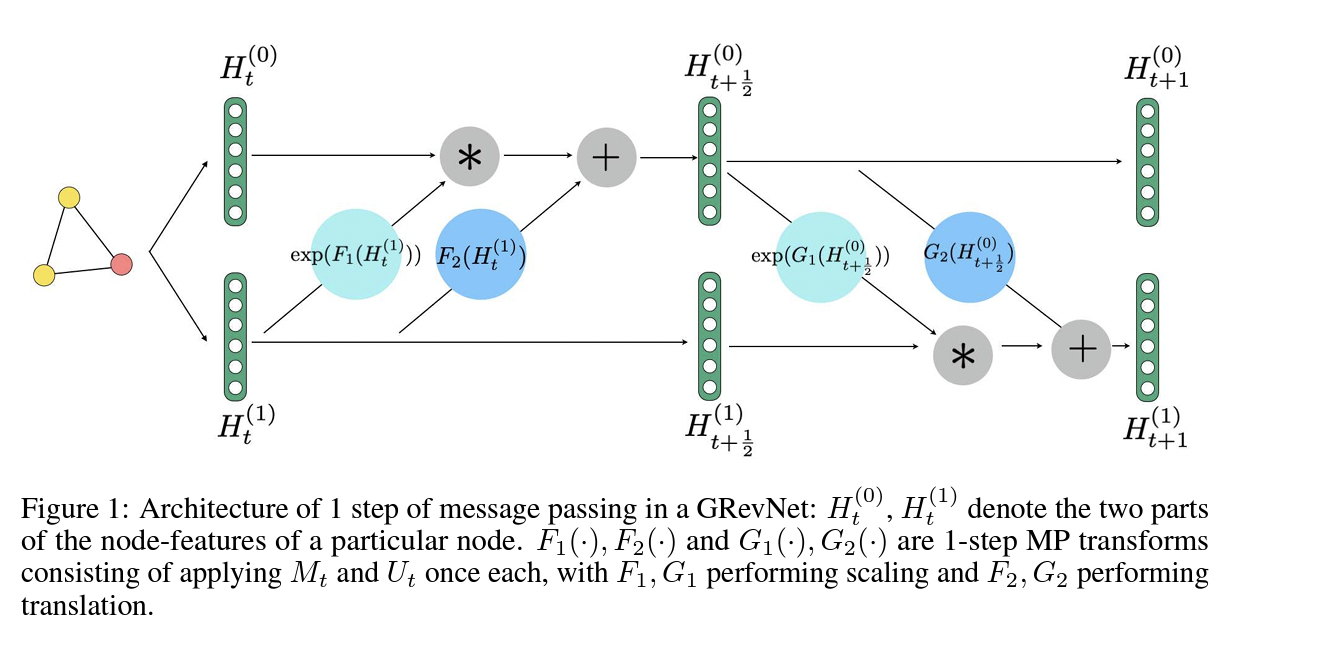

This is one single block of Reversible Graph Neural Networks.

In [20]:
mesh_graph = en_to_graph(mesh)
mesh_from_graph = graph_to_en(mesh_graph)

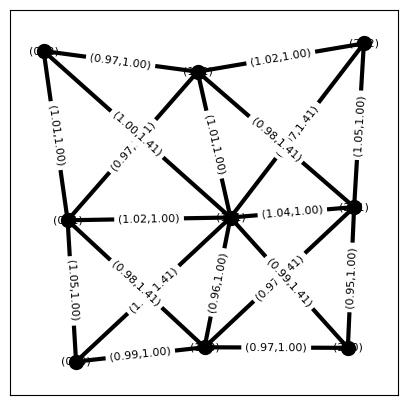

In [21]:
mesh.draw()

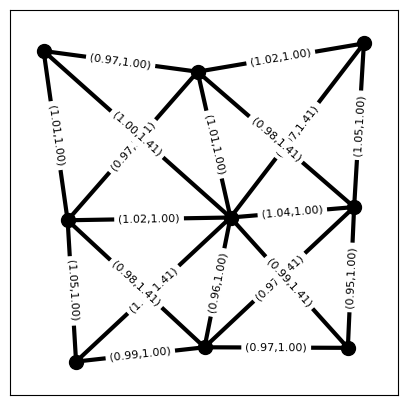

In [22]:
mesh_from_graph.draw()

In [23]:
assert mesh.energy() == mesh_from_graph.energy()

In [24]:
def invert_test(g):
    m = GRevNet(n_layers=4, dim=2, hidden_dim=16)
    g, ld_fwd = m.forward(g)
    g, ld_rev = m.reverse(g)
    jax.debug.print(f"Log det of Jacobian, fwd: {ld_fwd:.2f}, rev: {ld_rev:.2f}")
    return g

rng_key = jax.random.PRNGKey(42)
invert_test = hk.without_apply_rng(hk.transform(invert_test))
params_invert_test = invert_test.init(rng=rng_key, g=mesh_graph)
output = invert_test.apply(params=params_invert_test, g=mesh_graph)

output


Log det of Jacobian, fwd: -0.61, rev: 0.61
Log det of Jacobian, fwd: -0.61, rev: 0.61


GraphsTuple(nodes=DeviceArray([[ 0.0492107 , -0.01623283],
             [-0.00804899,  0.91145486],
             [-0.17099029,  2.0224059 ],
             [ 0.92168844,  0.07765711],
             [ 1.0979779 ,  0.92953306],
             [ 0.8746149 ,  1.8866518 ],
             [ 1.894645  ,  0.07398704],
             [ 1.9372722 ,  0.99792016],
             [ 2.0034301 ,  2.0723157 ]], dtype=float32), edges=DeviceArray([[1.        , 0.987454  ],
             [1.        , 1.0450715 ],
             [1.4142135 , 1.0332443 ],
             [1.        , 1.0231994 ],
             [1.        , 1.0098659 ],
             [1.4142135 , 0.9712339 ],
             [1.4142135 , 0.9804242 ],
             [1.        , 0.96560186],
             [1.4142135 , 1.0024756 ],
             [1.        , 0.9655995 ],
             [1.        , 0.95580834],
             [1.4142135 , 0.9681825 ],
             [1.        , 1.0366176 ],
             [1.        , 1.0101115 ],
             [1.4142135 , 0.96834046],
     

In [25]:
mesh_graph

GraphsTuple(nodes=DeviceArray([[ 0.04921072, -0.01623286],
             [-0.00804867,  0.9114548 ],
             [-0.17099024,  2.022406  ],
             [ 0.92168844,  0.07765714],
             [ 1.0979779 ,  0.92953336],
             [ 0.874615  ,  1.8866516 ],
             [ 1.8946449 ,  0.07398707],
             [ 1.937272  ,  0.99792016],
             [ 2.0034301 ,  2.0723157 ]], dtype=float32), edges=DeviceArray([[1.        , 0.987454  ],
             [1.        , 1.0450715 ],
             [1.4142135 , 1.0332443 ],
             [1.        , 1.0231994 ],
             [1.        , 1.0098659 ],
             [1.4142135 , 0.9712339 ],
             [1.4142135 , 0.9804242 ],
             [1.        , 0.96560186],
             [1.4142135 , 1.0024756 ],
             [1.        , 0.9655995 ],
             [1.        , 0.95580834],
             [1.4142135 , 0.9681825 ],
             [1.        , 1.0366176 ],
             [1.        , 1.0101115 ],
             [1.4142135 , 0.96834046],
     

Next, we will prepare tthe training data for our GNF NN. The idea is simple. We will sample some configurations of the same elastic network system (so same topology, spring constants, and equilibrium lengths). Then we convert configuration snapshots into jraph graphs for training.

After that we will define the loss function that takes a batch of graphs and return the loss (MC estimate of KL divergence between the canonical distribution and the GNF-modeled distribution. This is exactly analogous to the simpler example with RealNVP net on the swiss roll dataset.

In [26]:
N, dN = 100000, 10
traj=mesh.sample(length=N)

In [27]:
training_data = []
for snapshot in traj[::dN]:
    mesh.pos = snapshot
    training_data.append(en_to_graph(mesh))
print(len(training_data))

10000


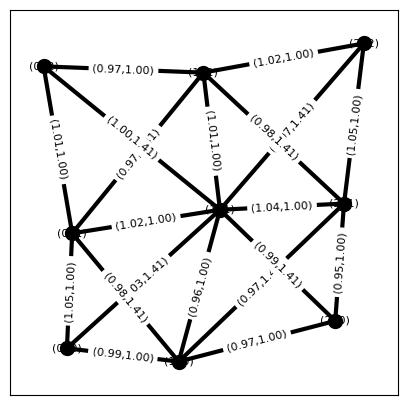

In [45]:
mesh.pos = traj[-100]
mesh.draw()

In [28]:
training_dataloader = []
batch_size = 20
for i in range(0, len(training_data), batch_size):
    batched_graph = jraph.batch(training_data[i:i+batch_size])
    training_dataloader.append(batched_graph)
print(len(training_dataloader))

500


In [29]:

# Note the GraphsTuple obj will be a batch of n_batch identical graphs 
# Loss function is based on forward KL divergence

def forward_KL(net_rev, params, x_batch): # x.shape = n_batch, 2 * n_channels
    loss = 0
    batch_out, ldj = net_rev.apply(params, x_batch)
    loss += -jnp.sum(optax.l2_loss(batch_out.nodes)) # assume iid standard gaussian dist on node features
    loss += ldj
    #jax.debug.print(f"LDJ: {ldj}")
    return -loss / batch_size

def reverse_KL(net_fwd, params, z_batch, T=1):
    loss = 0
    batch_out, ldj = net_fwd.apply(params, z_batch)
    graphs = jraph.unbatch(batch_out)
    total_energy = 0
    for graph in graphs:
        en = graph_to_en(graph)
        total_energy += en.energy()
    loss += 1/T * total_energy 
    loss += ldj # we ignore log p_u term because it's not affected by model param
    return -loss / batch_size

def combined_KL(net_fwd, net_rev, params, x_batch, z_batch):
    loss = 0.2*forward_KL(net_rev, params, x_batch) + 0.8*reverse_KL(net_fwd, params, z_batch)

In [30]:
def initial_fit(net_rev, training_dataloader, params, optimizer, epochs) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(forward_KL, argnums=1)(net_rev, params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(epochs):
        for i, batch in enumerate(training_dataloader):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Epoch {epoch}, loss: {loss_value}')

    return params

Finally, we initialize our model parameters and the optimizer and start fitting using the simulated dataset!

In [32]:
rng_key = jax.random.PRNGKey(42)
net_rev = hk.without_apply_rng(hk.transform(lambda g: GRevNet(n_layers=2, dim=2, hidden_dim=16).reverse(g) ))
params = net_rev.init(rng=rng_key, g=mesh_graph)

optimizer = optax.adam(learning_rate=1e-5)
params = initial_fit(net_rev, training_dataloader, params, optimizer, 10000)

Epoch 0, loss: 16.55481719970703
Epoch 1, loss: 11.190953254699707
Epoch 2, loss: 8.167582511901855
Epoch 3, loss: 5.973476409912109
Epoch 4, loss: 4.356729030609131
Epoch 5, loss: 3.165759325027466
Epoch 6, loss: 1.8365532159805298
Epoch 7, loss: 0.17096100747585297
Epoch 8, loss: -1.3058799505233765
Epoch 9, loss: -2.1578125953674316
Epoch 10, loss: -2.8035049438476562
Epoch 11, loss: -3.3778023719787598
Epoch 12, loss: -3.9706056118011475
Epoch 13, loss: -4.5787034034729
Epoch 14, loss: -5.146728515625
Epoch 15, loss: -5.651204586029053
Epoch 16, loss: -6.088977813720703
Epoch 17, loss: -6.5140228271484375
Epoch 18, loss: -6.90009069442749
Epoch 19, loss: -7.248419284820557
Epoch 20, loss: -7.599531650543213
Epoch 21, loss: -7.94415807723999
Epoch 22, loss: -8.246947288513184
Epoch 23, loss: -8.48072338104248
Epoch 24, loss: -8.682095527648926
Epoch 25, loss: -8.88635540008545
Epoch 26, loss: -9.108696937561035
Epoch 27, loss: -9.34558391571045
Epoch 28, loss: -9.57932186126709
Epoc

Epoch 228, loss: -18.485145568847656
Epoch 229, loss: -18.49708366394043
Epoch 230, loss: -18.511329650878906
Epoch 231, loss: -18.535184860229492
Epoch 232, loss: -18.576993942260742
Epoch 233, loss: -18.60262680053711
Epoch 234, loss: -18.650466918945312
Epoch 235, loss: -18.685510635375977
Epoch 236, loss: -18.730384826660156
Epoch 237, loss: -18.76082420349121
Epoch 238, loss: -18.798477172851562
Epoch 239, loss: -18.83146095275879
Epoch 240, loss: -18.85774803161621
Epoch 241, loss: -18.89356231689453
Epoch 242, loss: -18.930795669555664
Epoch 243, loss: -18.97943687438965
Epoch 244, loss: -19.021350860595703
Epoch 245, loss: -19.05307960510254
Epoch 246, loss: -19.09315299987793
Epoch 247, loss: -19.126554489135742
Epoch 248, loss: -19.166000366210938
Epoch 249, loss: -19.204559326171875
Epoch 250, loss: -19.230892181396484
Epoch 251, loss: -19.260038375854492
Epoch 252, loss: -19.293533325195312
Epoch 253, loss: -19.326824188232422
Epoch 254, loss: -19.356313705444336
Epoch 255,

Epoch 452, loss: -20.784637451171875
Epoch 453, loss: -20.786706924438477
Epoch 454, loss: -20.81365966796875
Epoch 455, loss: -20.792573928833008
Epoch 456, loss: -20.797006607055664
Epoch 457, loss: -20.802820205688477
Epoch 458, loss: -20.80486488342285
Epoch 459, loss: -20.805173873901367
Epoch 460, loss: -20.796680450439453
Epoch 461, loss: -20.81801414489746
Epoch 462, loss: -20.81204605102539
Epoch 463, loss: -20.81241798400879
Epoch 464, loss: -20.82114601135254
Epoch 465, loss: -20.816823959350586
Epoch 466, loss: -20.82733726501465
Epoch 467, loss: -20.838809967041016
Epoch 468, loss: -20.845687866210938
Epoch 469, loss: -20.843259811401367
Epoch 470, loss: -20.85613441467285
Epoch 471, loss: -20.862733840942383
Epoch 472, loss: -20.868938446044922
Epoch 473, loss: -20.876697540283203
Epoch 474, loss: -20.879596710205078
Epoch 475, loss: -20.895095825195312
Epoch 476, loss: -20.898574829101562
Epoch 477, loss: -20.91224479675293
Epoch 478, loss: -20.9121150970459
Epoch 479, l

Epoch 677, loss: -21.290454864501953
Epoch 678, loss: -21.276641845703125
Epoch 679, loss: -21.281002044677734
Epoch 680, loss: -21.287656784057617
Epoch 681, loss: -21.28462028503418
Epoch 682, loss: -21.309391021728516
Epoch 683, loss: -21.28462028503418
Epoch 684, loss: -21.295272827148438
Epoch 685, loss: -21.29290771484375
Epoch 686, loss: -21.29312515258789
Epoch 687, loss: -21.284360885620117
Epoch 688, loss: -21.288677215576172
Epoch 689, loss: -21.295312881469727
Epoch 690, loss: -21.296085357666016
Epoch 691, loss: -21.29791831970215
Epoch 692, loss: -21.3054256439209
Epoch 693, loss: -21.3074893951416
Epoch 694, loss: -21.314105987548828
Epoch 695, loss: -21.30291175842285
Epoch 696, loss: -21.314395904541016
Epoch 697, loss: -21.30958366394043
Epoch 698, loss: -21.315200805664062
Epoch 699, loss: -21.307775497436523
Epoch 700, loss: -21.303791046142578
Epoch 701, loss: -21.29612922668457
Epoch 702, loss: -21.29530906677246
Epoch 703, loss: -21.294952392578125
Epoch 704, los

Epoch 901, loss: -21.709064483642578
Epoch 902, loss: -21.709644317626953
Epoch 903, loss: -21.7100772857666
Epoch 904, loss: -21.72138214111328
Epoch 905, loss: -21.723134994506836
Epoch 906, loss: -21.717153549194336
Epoch 907, loss: -21.734617233276367
Epoch 908, loss: -21.730220794677734
Epoch 909, loss: -21.726871490478516
Epoch 910, loss: -21.73225212097168
Epoch 911, loss: -21.74786949157715
Epoch 912, loss: -21.74626350402832
Epoch 913, loss: -21.742467880249023
Epoch 914, loss: -21.759923934936523
Epoch 915, loss: -21.762149810791016
Epoch 916, loss: -21.774450302124023
Epoch 917, loss: -21.761823654174805
Epoch 918, loss: -21.7679500579834
Epoch 919, loss: -21.775991439819336
Epoch 920, loss: -21.778667449951172
Epoch 921, loss: -21.764633178710938
Epoch 922, loss: -21.7727108001709
Epoch 923, loss: -21.785783767700195
Epoch 924, loss: -21.773426055908203
Epoch 925, loss: -21.76446533203125
Epoch 926, loss: -21.796659469604492
Epoch 927, loss: -21.78080177307129
Epoch 928, lo

Epoch 1122, loss: -22.063812255859375
Epoch 1123, loss: -22.079343795776367
Epoch 1124, loss: -22.0946102142334
Epoch 1125, loss: -22.1077823638916
Epoch 1126, loss: -22.093032836914062
Epoch 1127, loss: -22.069801330566406
Epoch 1128, loss: -22.088451385498047
Epoch 1129, loss: -22.09068489074707
Epoch 1130, loss: -22.092641830444336
Epoch 1131, loss: -22.093414306640625
Epoch 1132, loss: -22.095741271972656
Epoch 1133, loss: -22.094696044921875
Epoch 1134, loss: -22.07474136352539
Epoch 1135, loss: -22.095901489257812
Epoch 1136, loss: -22.094953536987305
Epoch 1137, loss: -22.11122703552246
Epoch 1138, loss: -22.100008010864258
Epoch 1139, loss: -22.104848861694336
Epoch 1140, loss: -22.10370445251465
Epoch 1141, loss: -22.097990036010742
Epoch 1142, loss: -22.115482330322266
Epoch 1143, loss: -22.103702545166016
Epoch 1144, loss: -22.114622116088867
Epoch 1145, loss: -22.124637603759766
Epoch 1146, loss: -22.118122100830078
Epoch 1147, loss: -22.1251277923584
Epoch 1148, loss: -22.

Epoch 1341, loss: -22.579395294189453
Epoch 1342, loss: -22.61383056640625
Epoch 1343, loss: -22.608747482299805
Epoch 1344, loss: -22.6209659576416
Epoch 1345, loss: -22.595304489135742
Epoch 1346, loss: -22.635889053344727
Epoch 1347, loss: -22.623685836791992
Epoch 1348, loss: -22.63283348083496
Epoch 1349, loss: -22.615873336791992
Epoch 1350, loss: -22.64444923400879
Epoch 1351, loss: -22.63620376586914
Epoch 1352, loss: -22.619873046875
Epoch 1353, loss: -22.623809814453125
Epoch 1354, loss: -22.64051628112793
Epoch 1355, loss: -22.626462936401367
Epoch 1356, loss: -22.6290340423584
Epoch 1357, loss: -22.63022232055664
Epoch 1358, loss: -22.633869171142578
Epoch 1359, loss: -22.61205291748047
Epoch 1360, loss: -22.623350143432617
Epoch 1361, loss: -22.61861228942871
Epoch 1362, loss: -22.644351959228516
Epoch 1363, loss: -22.633331298828125
Epoch 1364, loss: -22.6359920501709
Epoch 1365, loss: -22.644750595092773
Epoch 1366, loss: -22.667964935302734
Epoch 1367, loss: -22.6574039

Epoch 1560, loss: -23.018735885620117
Epoch 1561, loss: -23.03605842590332
Epoch 1562, loss: -23.019933700561523
Epoch 1563, loss: -23.023603439331055
Epoch 1564, loss: -23.020505905151367
Epoch 1565, loss: -23.001066207885742
Epoch 1566, loss: -23.008634567260742
Epoch 1567, loss: -23.0028076171875
Epoch 1568, loss: -22.99472427368164
Epoch 1569, loss: -23.009166717529297
Epoch 1570, loss: -22.96718406677246
Epoch 1571, loss: -22.989791870117188
Epoch 1572, loss: -22.971755981445312
Epoch 1573, loss: -23.002737045288086
Epoch 1574, loss: -23.008136749267578
Epoch 1575, loss: -23.013233184814453
Epoch 1576, loss: -23.02662467956543
Epoch 1577, loss: -23.03102684020996
Epoch 1578, loss: -23.000776290893555
Epoch 1579, loss: -23.02790641784668
Epoch 1580, loss: -23.00166893005371
Epoch 1581, loss: -23.023754119873047
Epoch 1582, loss: -23.008777618408203
Epoch 1583, loss: -23.016687393188477
Epoch 1584, loss: -23.019323348999023
Epoch 1585, loss: -23.02837562561035
Epoch 1586, loss: -23.

Epoch 1778, loss: -23.038541793823242
Epoch 1779, loss: -23.066043853759766
Epoch 1780, loss: -23.08487319946289
Epoch 1781, loss: -23.0683536529541
Epoch 1782, loss: -23.053651809692383
Epoch 1783, loss: -23.068883895874023
Epoch 1784, loss: -23.054922103881836
Epoch 1785, loss: -23.057083129882812
Epoch 1786, loss: -23.07439422607422
Epoch 1787, loss: -23.044588088989258
Epoch 1788, loss: -23.055688858032227
Epoch 1789, loss: -23.06719398498535
Epoch 1790, loss: -23.07454490661621
Epoch 1791, loss: -23.054332733154297
Epoch 1792, loss: -23.090106964111328
Epoch 1793, loss: -23.063552856445312
Epoch 1794, loss: -23.10616111755371
Epoch 1795, loss: -23.09090232849121
Epoch 1796, loss: -23.09470558166504
Epoch 1797, loss: -23.105335235595703
Epoch 1798, loss: -23.09821128845215
Epoch 1799, loss: -23.09601593017578
Epoch 1800, loss: -23.093801498413086
Epoch 1801, loss: -23.080188751220703
Epoch 1802, loss: -23.100509643554688
Epoch 1803, loss: -23.10524559020996
Epoch 1804, loss: -23.09

Epoch 1997, loss: -23.337797164916992
Epoch 1998, loss: -23.357572555541992
Epoch 1999, loss: -23.34823989868164
Epoch 2000, loss: -23.35040283203125
Epoch 2001, loss: -23.34286117553711
Epoch 2002, loss: -23.3527774810791
Epoch 2003, loss: -23.34881591796875
Epoch 2004, loss: -23.351858139038086
Epoch 2005, loss: -23.34000015258789
Epoch 2006, loss: -23.334707260131836
Epoch 2007, loss: -23.35953140258789
Epoch 2008, loss: -23.347047805786133
Epoch 2009, loss: -23.363758087158203
Epoch 2010, loss: -23.350234985351562
Epoch 2011, loss: -23.34720802307129
Epoch 2012, loss: -23.33236312866211
Epoch 2013, loss: -23.35689353942871
Epoch 2014, loss: -23.3509464263916
Epoch 2015, loss: -23.360097885131836
Epoch 2016, loss: -23.372201919555664
Epoch 2017, loss: -23.333040237426758
Epoch 2018, loss: -23.335208892822266
Epoch 2019, loss: -23.3475341796875
Epoch 2020, loss: -23.3636531829834
Epoch 2021, loss: -23.353673934936523
Epoch 2022, loss: -23.372411727905273
Epoch 2023, loss: -23.3737697

Epoch 2215, loss: -23.619600296020508
Epoch 2216, loss: -23.627567291259766
Epoch 2217, loss: -23.63802719116211
Epoch 2218, loss: -23.639450073242188
Epoch 2219, loss: -23.61673927307129
Epoch 2220, loss: -23.660091400146484
Epoch 2221, loss: -23.645435333251953
Epoch 2222, loss: -23.64520263671875
Epoch 2223, loss: -23.617948532104492
Epoch 2224, loss: -23.65167808532715
Epoch 2225, loss: -23.636533737182617
Epoch 2226, loss: -23.66888999938965
Epoch 2227, loss: -23.661941528320312
Epoch 2228, loss: -23.670520782470703
Epoch 2229, loss: -23.669710159301758
Epoch 2230, loss: -23.65117645263672
Epoch 2231, loss: -23.65142250061035
Epoch 2232, loss: -23.66135597229004
Epoch 2233, loss: -23.651151657104492
Epoch 2234, loss: -23.650226593017578
Epoch 2235, loss: -23.653888702392578
Epoch 2236, loss: -23.64780616760254
Epoch 2237, loss: -23.62889862060547
Epoch 2238, loss: -23.664663314819336
Epoch 2239, loss: -23.66228485107422
Epoch 2240, loss: -23.658180236816406
Epoch 2241, loss: -23.6

Epoch 2434, loss: -23.795368194580078
Epoch 2435, loss: -23.81243896484375
Epoch 2436, loss: -23.79298973083496
Epoch 2437, loss: -23.803386688232422
Epoch 2438, loss: -23.821767807006836
Epoch 2439, loss: -23.827585220336914
Epoch 2440, loss: -23.834238052368164
Epoch 2441, loss: -23.825349807739258
Epoch 2442, loss: -23.82486915588379
Epoch 2443, loss: -23.84444808959961
Epoch 2444, loss: -23.843685150146484
Epoch 2445, loss: -23.84119987487793
Epoch 2446, loss: -23.823104858398438
Epoch 2447, loss: -23.850919723510742
Epoch 2448, loss: -23.845813751220703
Epoch 2449, loss: -23.84808349609375
Epoch 2450, loss: -23.845237731933594
Epoch 2451, loss: -23.841720581054688
Epoch 2452, loss: -23.88080406188965
Epoch 2453, loss: -23.85654640197754
Epoch 2454, loss: -23.850431442260742
Epoch 2455, loss: -23.87984848022461
Epoch 2456, loss: -23.86724090576172
Epoch 2457, loss: -23.88315200805664
Epoch 2458, loss: -23.879024505615234
Epoch 2459, loss: -23.88050651550293
Epoch 2460, loss: -23.87

Epoch 2653, loss: -24.2763729095459
Epoch 2654, loss: -24.25053596496582
Epoch 2655, loss: -24.2802791595459
Epoch 2656, loss: -24.272634506225586
Epoch 2657, loss: -24.255069732666016
Epoch 2658, loss: -24.285558700561523
Epoch 2659, loss: -24.28867530822754
Epoch 2660, loss: -24.30459976196289
Epoch 2661, loss: -24.28466796875
Epoch 2662, loss: -24.283180236816406
Epoch 2663, loss: -24.309019088745117
Epoch 2664, loss: -24.285099029541016
Epoch 2665, loss: -24.253494262695312
Epoch 2666, loss: -24.31723403930664
Epoch 2667, loss: -24.284353256225586
Epoch 2668, loss: -24.30847930908203
Epoch 2669, loss: -24.309656143188477
Epoch 2670, loss: -24.294965744018555
Epoch 2671, loss: -24.321176528930664
Epoch 2672, loss: -24.294540405273438
Epoch 2673, loss: -24.32582664489746
Epoch 2674, loss: -24.293691635131836
Epoch 2675, loss: -24.313444137573242
Epoch 2676, loss: -24.301218032836914
Epoch 2677, loss: -24.32308578491211
Epoch 2678, loss: -24.313467025756836
Epoch 2679, loss: -24.30779

Epoch 2872, loss: -24.501972198486328
Epoch 2873, loss: -24.476058959960938
Epoch 2874, loss: -24.477750778198242
Epoch 2875, loss: -24.459630966186523
Epoch 2876, loss: -24.4852294921875
Epoch 2877, loss: -24.495868682861328
Epoch 2878, loss: -24.519058227539062
Epoch 2879, loss: -24.497488021850586
Epoch 2880, loss: -24.484594345092773
Epoch 2881, loss: -24.47063446044922
Epoch 2882, loss: -24.499225616455078
Epoch 2883, loss: -24.49547576904297
Epoch 2884, loss: -24.504623413085938
Epoch 2885, loss: -24.512468338012695
Epoch 2886, loss: -24.493757247924805
Epoch 2887, loss: -24.50818634033203
Epoch 2888, loss: -24.515872955322266
Epoch 2889, loss: -24.53232192993164
Epoch 2890, loss: -24.51064109802246
Epoch 2891, loss: -24.51728630065918
Epoch 2892, loss: -24.540117263793945
Epoch 2893, loss: -24.49835205078125
Epoch 2894, loss: -24.525602340698242
Epoch 2895, loss: -24.530256271362305
Epoch 2896, loss: -24.507837295532227
Epoch 2897, loss: -24.514616012573242
Epoch 2898, loss: -24

Epoch 3090, loss: -24.697879791259766
Epoch 3091, loss: -24.73276138305664
Epoch 3092, loss: -24.696819305419922
Epoch 3093, loss: -24.722259521484375
Epoch 3094, loss: -24.710844039916992
Epoch 3095, loss: -24.683591842651367
Epoch 3096, loss: -24.701766967773438
Epoch 3097, loss: -24.73447036743164
Epoch 3098, loss: -24.72395133972168
Epoch 3099, loss: -24.72992515563965
Epoch 3100, loss: -24.7313175201416
Epoch 3101, loss: -24.717151641845703
Epoch 3102, loss: -24.72098731994629
Epoch 3103, loss: -24.72395133972168
Epoch 3104, loss: -24.74941062927246
Epoch 3105, loss: -24.69692039489746
Epoch 3106, loss: -24.6795597076416
Epoch 3107, loss: -24.740520477294922
Epoch 3108, loss: -24.764772415161133
Epoch 3109, loss: -24.74610710144043
Epoch 3110, loss: -24.75164222717285
Epoch 3111, loss: -24.756277084350586
Epoch 3112, loss: -24.751066207885742
Epoch 3113, loss: -24.7611026763916
Epoch 3114, loss: -24.74606704711914
Epoch 3115, loss: -24.729379653930664
Epoch 3116, loss: -24.7463073

Epoch 3309, loss: -24.811328887939453
Epoch 3310, loss: -24.82598304748535
Epoch 3311, loss: -24.74240493774414
Epoch 3312, loss: -24.80732536315918
Epoch 3313, loss: -24.792482376098633
Epoch 3314, loss: -24.811511993408203
Epoch 3315, loss: -24.771764755249023
Epoch 3316, loss: -24.77174949645996
Epoch 3317, loss: -24.756139755249023
Epoch 3318, loss: -24.793100357055664
Epoch 3319, loss: -24.798221588134766
Epoch 3320, loss: -24.829946517944336
Epoch 3321, loss: -24.82746124267578
Epoch 3322, loss: -24.77851104736328
Epoch 3323, loss: -24.791248321533203
Epoch 3324, loss: -24.810317993164062
Epoch 3325, loss: -24.826353073120117
Epoch 3326, loss: -24.7982120513916
Epoch 3327, loss: -24.797378540039062
Epoch 3328, loss: -24.786176681518555
Epoch 3329, loss: -24.788497924804688
Epoch 3330, loss: -24.799083709716797
Epoch 3331, loss: -24.78346061706543
Epoch 3332, loss: -24.799421310424805
Epoch 3333, loss: -24.785306930541992
Epoch 3334, loss: -24.788969039916992
Epoch 3335, loss: -24

Epoch 3527, loss: -24.961477279663086
Epoch 3528, loss: -24.952533721923828
Epoch 3529, loss: -24.96134376525879
Epoch 3530, loss: -24.94443130493164
Epoch 3531, loss: -24.927949905395508
Epoch 3532, loss: -24.959516525268555
Epoch 3533, loss: -24.962385177612305
Epoch 3534, loss: -24.968229293823242
Epoch 3535, loss: -24.962453842163086
Epoch 3536, loss: -24.973730087280273
Epoch 3537, loss: -24.98716163635254
Epoch 3538, loss: -25.0057315826416
Epoch 3539, loss: -24.98710060119629
Epoch 3540, loss: -24.98630714416504
Epoch 3541, loss: -24.98805046081543
Epoch 3542, loss: -25.001937866210938
Epoch 3543, loss: -24.97060203552246
Epoch 3544, loss: -24.977792739868164
Epoch 3545, loss: -24.991943359375
Epoch 3546, loss: -25.003129959106445
Epoch 3547, loss: -25.0003719329834
Epoch 3548, loss: -24.986974716186523
Epoch 3549, loss: -24.973920822143555
Epoch 3550, loss: -24.977521896362305
Epoch 3551, loss: -24.978303909301758
Epoch 3552, loss: -25.015310287475586
Epoch 3553, loss: -25.0219

Epoch 3746, loss: -25.185501098632812
Epoch 3747, loss: -25.202417373657227
Epoch 3748, loss: -25.145709991455078
Epoch 3749, loss: -25.21149253845215
Epoch 3750, loss: -25.158584594726562
Epoch 3751, loss: -25.19991111755371
Epoch 3752, loss: -25.190521240234375
Epoch 3753, loss: -25.219711303710938
Epoch 3754, loss: -25.20530128479004
Epoch 3755, loss: -25.12868309020996
Epoch 3756, loss: -25.19192886352539
Epoch 3757, loss: -25.14851188659668
Epoch 3758, loss: -25.172592163085938
Epoch 3759, loss: -25.189725875854492
Epoch 3760, loss: -25.170333862304688
Epoch 3761, loss: -25.18549156188965
Epoch 3762, loss: -25.17875862121582
Epoch 3763, loss: -25.190462112426758
Epoch 3764, loss: -25.19886589050293
Epoch 3765, loss: -25.179462432861328
Epoch 3766, loss: -25.202497482299805
Epoch 3767, loss: -25.217639923095703
Epoch 3768, loss: -25.1884765625
Epoch 3769, loss: -25.221200942993164
Epoch 3770, loss: -25.19854164123535
Epoch 3771, loss: -25.169546127319336
Epoch 3772, loss: -25.16236

Epoch 3964, loss: -25.280517578125
Epoch 3965, loss: -25.1451416015625
Epoch 3966, loss: -25.23402976989746
Epoch 3967, loss: -25.282331466674805
Epoch 3968, loss: -25.211217880249023
Epoch 3969, loss: -25.18316650390625
Epoch 3970, loss: -25.279287338256836
Epoch 3971, loss: -25.27876853942871
Epoch 3972, loss: -25.280057907104492
Epoch 3973, loss: -25.24579620361328
Epoch 3974, loss: -25.206506729125977
Epoch 3975, loss: -25.273513793945312
Epoch 3976, loss: -25.217084884643555
Epoch 3977, loss: -25.133031845092773
Epoch 3978, loss: -25.23164939880371
Epoch 3979, loss: -25.17367172241211
Epoch 3980, loss: -25.257883071899414
Epoch 3981, loss: -25.1915283203125
Epoch 3982, loss: -25.243305206298828
Epoch 3983, loss: -25.2424373626709
Epoch 3984, loss: -25.181106567382812
Epoch 3985, loss: -25.237398147583008
Epoch 3986, loss: -25.248559951782227
Epoch 3987, loss: -25.21082305908203
Epoch 3988, loss: -25.317867279052734
Epoch 3989, loss: -25.3297061920166
Epoch 3990, loss: -25.29207801

KeyboardInterrupt: 

In [46]:
# save params
import pickle as pkl
with open("doubly_triangulated_3_3_params.pkl", 'wb') as file:
    pkl.dump(params, file)

In [37]:
net_fwd = hk.without_apply_rng(hk.transform(lambda g: GRevNet(n_layers=2, dim=2, hidden_dim=16).forward(g) ))

def generate_and_visualize(n_rows, n_cols, initial_seed=42, stddev=0.1, figsize=(5, 5)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    next_key = jax.random.PRNGKey(initial_seed)
    for i, j in product(range(n_rows), range(n_cols)):
        rng_key, next_key = jax.random.split(next_key)
        random_node_feats = stddev*jax.random.normal(rng_key, shape=mesh_graph.nodes.shape)
        #random_node_feats = jnp.zeros_like(mesh_graph.nodes)
        random_graph = replace_node_features(mesh_graph, random_node_feats)
        generated_graph, _ = net_fwd.apply(params=params, g=random_graph)
        generated_en = graph_to_en(generated_graph)
        generated_en.draw(ax=axes[i][j])
        print(f"Energy of generated elastic network: {generated_en.energy()}")
    return generated_graph

Energy of generated elastic network: 7.000656604766846
Energy of generated elastic network: 16.886272430419922
Energy of generated elastic network: 7.406683921813965
Energy of generated elastic network: 12.548810958862305
Energy of generated elastic network: 8.809446334838867
Energy of generated elastic network: 9.133875846862793
Energy of generated elastic network: 11.471837043762207
Energy of generated elastic network: 7.828612804412842
Energy of generated elastic network: 31.88470458984375
Energy of generated elastic network: 5.704992771148682


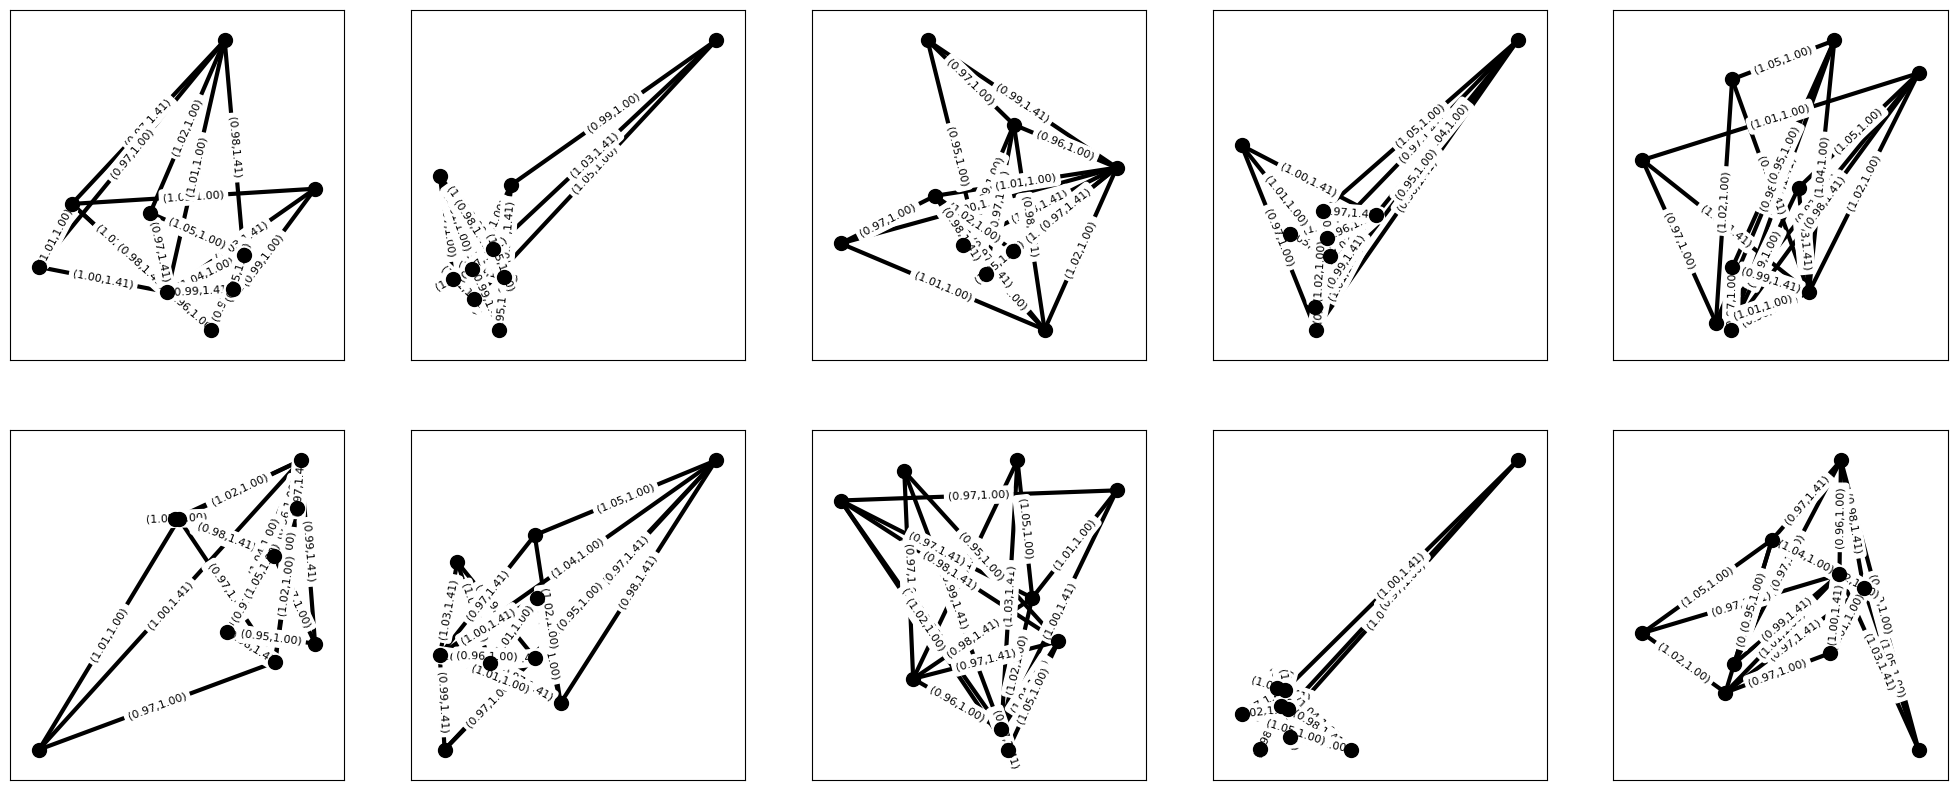

In [43]:
generated_graph = generate_and_visualize(2, 5, figsize=(25, 10), stddev=1)